**Final Exam Deep Learning**

Name : Natasha Kayla Cahyadi

ID : 2702235891

Class : LB09

**Link Video : https://drive.google.com/drive/folders/12zRhDeG471S5ekGaX6vvwDh0d0Ux1Syt?usp=sharing**

# Import Libraries

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# Data Preparation

In [283]:
# Load the dataset
df = pd.read_csv('AP004.csv')

In [284]:
# Display the data
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 non-null 

Based on the results above, it can be observed that nearly all columns in the dataset contain missing values. All columns also have a float data type, which supports future time series processing, except for **'from\_date'** and **'to\_date'**, which serve as the index in this dataset.

In [286]:
# Show statistics descriptive
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PM2.5 (ug/m3),46344.0,34.821967,30.785200,0.25,12.00,25.00,51.25,723.00
PM10 (ug/m3),46917.0,71.598595,48.312579,0.25,34.50,59.75,100.50,835.50
NO (ug/m3),47244.0,2.509505,5.058787,0.03,1.45,1.90,2.60,216.17
NO2 (ug/m3),47224.0,15.284711,10.415231,0.10,8.45,12.80,19.30,166.25
NOx (ppb),46628.0,10.025558,7.179902,0.00,6.00,8.47,12.15,166.00
NH3 (ug/m3),47140.0,13.382927,7.847778,0.10,8.20,11.90,17.00,118.25
SO2 (ug/m3),46649.0,8.498869,6.086666,0.10,4.92,7.25,10.37,183.30
CO (mg/m3),46387.0,0.693976,0.437964,0.00,0.43,0.63,0.88,18.69
Ozone (ug/m3),47156.0,40.931671,32.651348,0.20,14.73,33.23,59.68,198.40
Benzene (ug/m3),46914.0,0.570979,0.800774,0.00,0.10,0.35,0.83,50.90


* Most features are within realistic environmental ranges.
* CO and BP values exceed real-world limits, indicating possible sensor errors.
* VWS contains negative values, which are physically invalid for wind speed.
* Toluene, Xylene, and Eth-Benzene have extremely high maximum values, likely due to outliers or noise.
* RH (%), RF (mm), and AT (°C) are within acceptable ranges.

# Data Preprocessing

## Check Duplicated Data

In [287]:
# Show duplicated data
print(df.duplicated().sum())

0


There are no duplicated entries in this dataset.

## Convert 'From Date' to Datetime

In [288]:
df['From Date'] = pd.to_datetime(df['From Date'])
df.set_index('From Date', inplace=True)

The **'From Date'** column is first converted to datetime format to ensure proper handling of time-based operations. It is then set as the index of the DataFrame, preparing the dataset for time series analysis.

In [289]:
# Drop 'To Date' column
df.drop(columns=['To Date'], inplace=True)

## Handle Missing Values

In [290]:
# Check total missing values per column
print(df.isnull().sum())

PM2.5 (ug/m3)           2458
PM10 (ug/m3)            1885
NO (ug/m3)              1558
NO2 (ug/m3)             1578
NOx (ppb)               2174
NH3 (ug/m3)             1662
SO2 (ug/m3)             2153
CO (mg/m3)              2415
Ozone (ug/m3)           1646
Benzene (ug/m3)         1888
Toluene (ug/m3)         1894
Eth-Benzene (ug/m3)    24814
MP-Xylene (ug/m3)       9546
Temp (degree C)        27203
RH (%)                  1438
WS (m/s)                1427
WD (degree)             1429
SR (W/mt2)              1656
BP (mmHg)               1429
VWS (m/s)               1626
AT (degree C)           1516
RF (mm)                 1292
Xylene (ug/m3)          1727
dtype: int64


* Most columns have missing values in a reasonable range (under 10%).
* **Eth-Benzene** has over 24,000 missing values, indicating over 50% data loss.
* **MP-Xylene** and **Temp (°C)** also have a high number of missing entries.
* Other columns like RH, WS, WD, SR, BP, VWS, and AT have relatively low missing values and can be interpolated safely.

In [291]:
# Get all rows where Eth-Benzene is missing
missing_rows = df[df['Eth-Benzene (ug/m3)'].isnull()]

# Convert index to DataFrame format
missing_index_df = missing_rows.index.to_frame(index=False)
missing_index_df.columns = ['Missing Index (Eth-Benzene)']

# Show first few rows as DataFrame
print(missing_index_df.head(30))

   Missing Index (Eth-Benzene)
0          2017-09-05 14:00:00
1          2017-09-05 15:00:00
2          2017-09-05 16:00:00
3          2017-09-05 17:00:00
4          2017-09-05 18:00:00
5          2017-09-05 19:00:00
6          2017-09-05 20:00:00
7          2017-09-05 21:00:00
8          2017-09-05 22:00:00
9          2017-09-05 23:00:00
10         2017-09-06 00:00:00
11         2017-09-06 01:00:00
12         2017-09-06 02:00:00
13         2017-09-06 03:00:00
14         2017-09-06 04:00:00
15         2017-09-06 05:00:00
16         2017-09-06 06:00:00
17         2017-09-06 07:00:00
18         2017-09-06 08:00:00
19         2017-09-06 09:00:00
20         2017-09-06 10:00:00
21         2017-09-06 11:00:00
22         2017-09-06 12:00:00
23         2017-09-06 13:00:00
24         2017-09-06 14:00:00
25         2017-09-06 15:00:00
26         2017-09-06 16:00:00
27         2017-09-06 17:00:00
28         2017-09-06 18:00:00
29         2017-09-06 19:00:00


The **'Eth-Benzene (ug/m3)'** column contains a high number of missing values (over 50%), and the missing values appear consecutively. Therefore, this column is dropped from the dataset.

In [293]:
df.drop(columns=['Eth-Benzene (ug/m3)'], inplace=True)

In [294]:
df['RF (mm)'] = df['RF (mm)'].fillna(0)

The missing values in the **'RF (mm)'** column are filled with 0, based on the assumption that NaN indicates no rainfall occurred on those days.

In [295]:
df = df.interpolate(method='time')

The dataset is interpolated using the **time-based method**, which fills missing values by considering the time index. This approach ensures that the estimated values follow the temporal patterns in the data.

In [296]:
# Check total missing values per column
print(df.isnull().sum().sum())

0


## Handle the Anomalies

### Interpolate

In [297]:
df.loc[df['VWS (m/s)'] < 0, 'VWS (m/s)'] = np.nan
df['VWS (m/s)'] = df['VWS (m/s)'].interpolate(method='time')

Any negative values in the **'VWS (m/s)'** column are considered invalid and replaced with NaN. These missing values are then filled using **time-based interpolation**, ensuring the data remains consistent with the temporal structure of the dataset.

### Capping

In [298]:
def cap_real_world_ranges(df):
    """
    Cap values in the dataset based on real-world thresholds.
    Values outside realistic physical/environmental limits are clipped.
    """
    df = df.copy()

    # Realistic min/max values (based on environmental standards)
    caps = {
        'PM2.5 (ug/m3)':       (0, 500),
        'PM10 (ug/m3)':        (0, 600),
        'NO (ug/m3)':          (0, 100),
        'NO2 (ug/m3)':         (0, 200),
        'NOx (ppb)':           (0, 200),
        'NH3 (ug/m3)':         (0, 200),
        'SO2 (ug/m3)':         (0, 150),
        'CO (mg/m3)':          (0, 10),
        'Ozone (ug/m3)':       (0, 200),
        'Benzene (ug/m3)':     (0, 5),
        'Toluene (ug/m3)':     (0, 100),
        'Eth-Benzene (ug/m3)': (0, 100),
        'MP-Xylene (ug/m3)':   (0, 100),
        'Xylene (ug/m3)':      (0, 100),
        'Temp (degree C)':     (-10, 55),
        'RH (%)':              (0, 100),
        'WS (m/s)':            (0, 30),
        'WD (degree)':         (0, 360),
        'SR (W/mt2)':          (0, 1200),
        'BP (mmHg)':           (720, 770),
        # 'VWS (m/s)':           (-3, 3),
        'AT (degree C)':       (-10, 60),
        'RF (mm)':             (0, 50),
    }

    # Apply clipping to each available column
    for col, (min_val, max_val) in caps.items():
        if col in df.columns:
            df[col] = df[col].clip(lower=min_val, upper=max_val)

    return df


This capping process is used to **pull back outliers** that do not make sense in real-life scenarios. By enforcing realistic environmental thresholds, it ensures that extreme or invalid values are adjusted to fall within acceptable physical limits.

In [299]:
df = cap_real_world_ranges(df)

# Exploratory Data Analysis

In [300]:
# Make an empty variable to store categorical and numerical columns
categorical_columns = []
numerical_columns = []

# Looping to divide categorical and numerical, then store it to an empty variable that we've made
for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        numerical_columns.append(i)
    else:
        categorical_columns.append(i)

# Display the categorical and numerical columns
print(f'Categorical: {categorical_columns}')
print(f'Numeric: {numerical_columns}')

Categorical: []
Numeric: ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'MP-Xylene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)', 'RF (mm)', 'Xylene (ug/m3)']


## Check Distribution

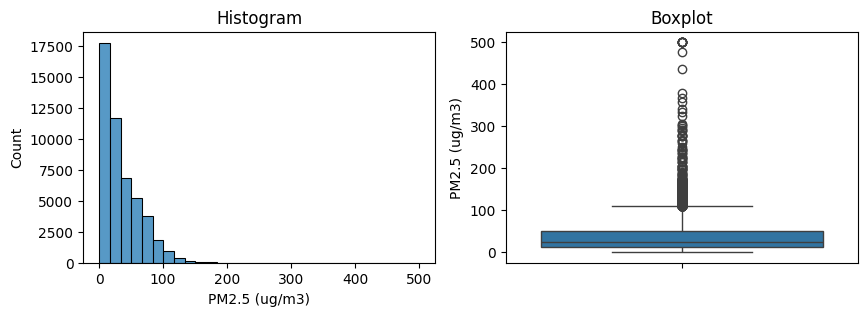

Skewness: 2.151791887422706
Kurtosis: 14.744807110319979


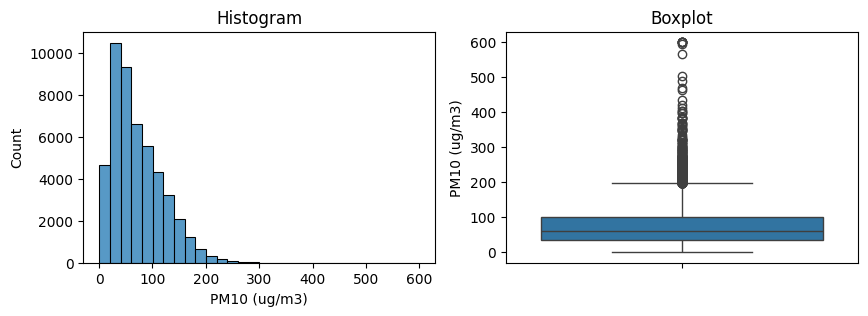

Skewness: 1.3113377294570905
Kurtosis: 4.153045611446574


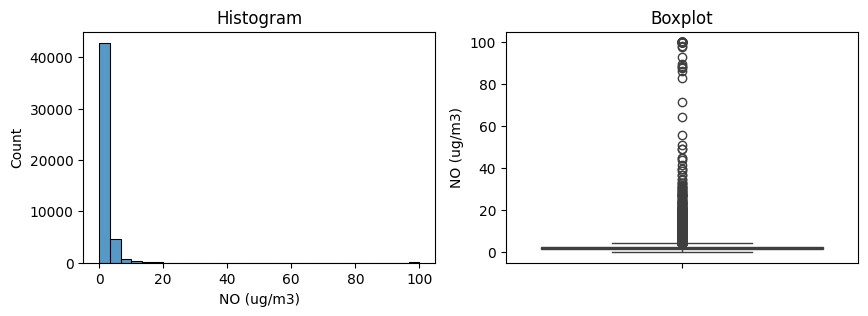

Skewness: 18.561218177987808
Kurtosis: 410.17119163715523


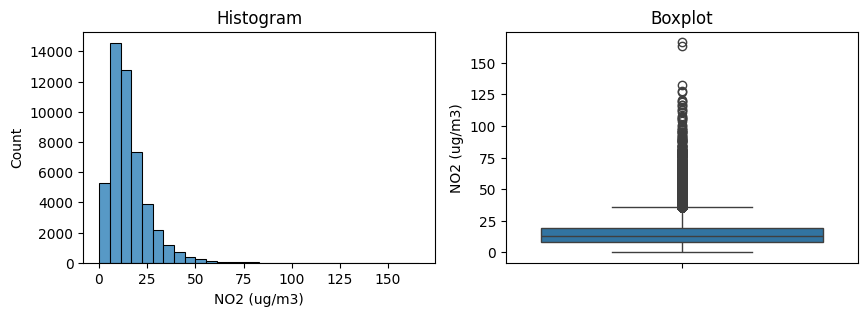

Skewness: 2.25644414188244
Kurtosis: 10.538676931419365


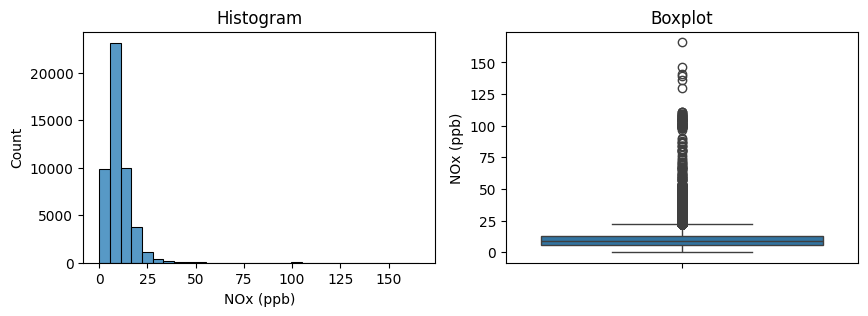

Skewness: 5.184640343903841
Kurtosis: 58.07338808422498


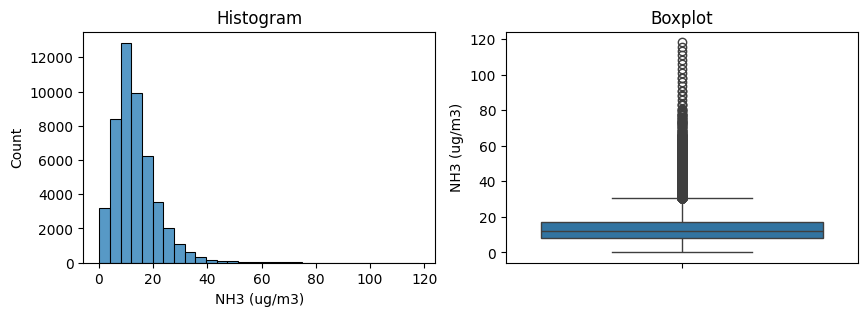

Skewness: 2.138055228287271
Kurtosis: 10.717613203128119


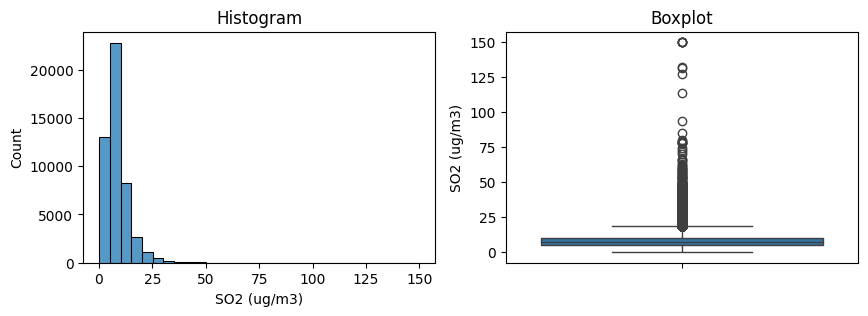

Skewness: 4.128558303972516
Kurtosis: 52.517523063602745


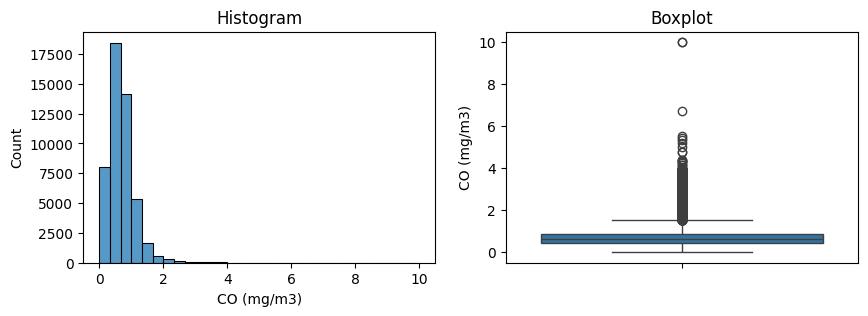

Skewness: 2.4893732803515776
Kurtosis: 19.089265081111893


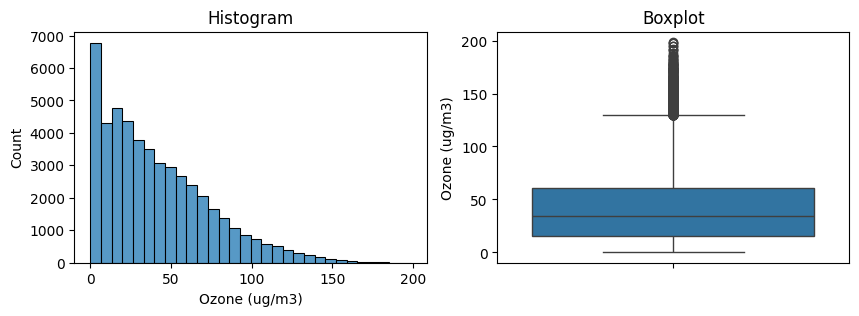

Skewness: 1.0324289083748763
Kurtosis: 0.7714887559666264


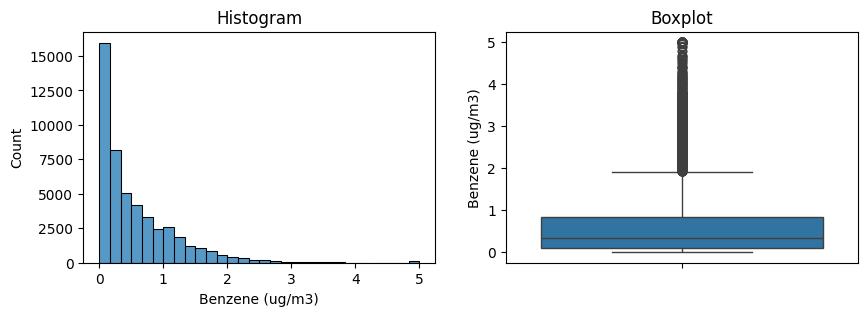

Skewness: 2.1903658231016063
Kurtosis: 7.597643127494436


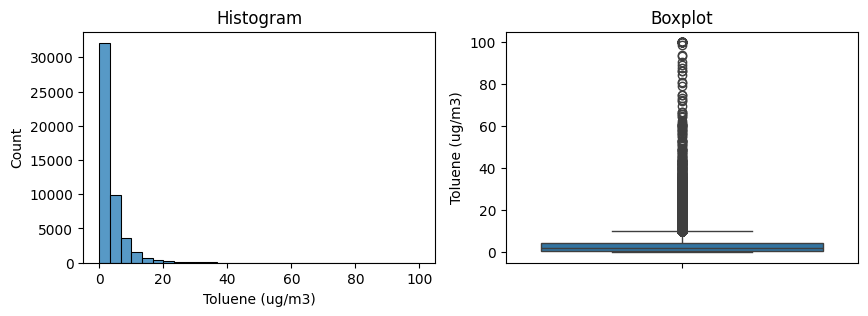

Skewness: 7.452501352111489
Kurtosis: 101.96257279197198


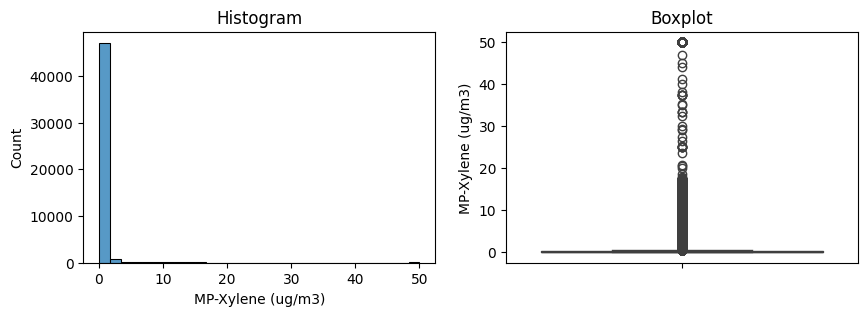

Skewness: 13.520859871517336
Kurtosis: 203.12127351837773


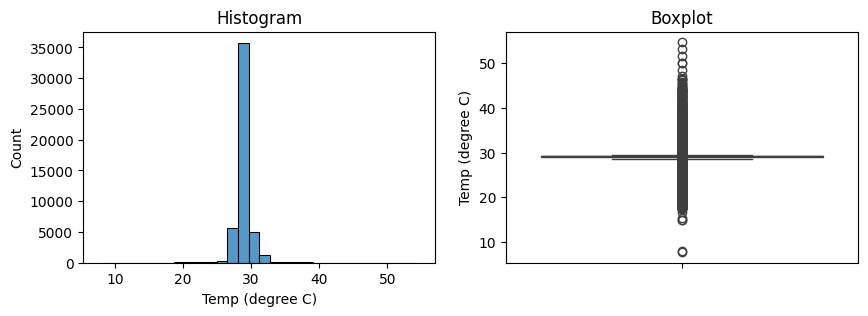

Skewness: 0.8635459651031294
Kurtosis: 40.12527730053766


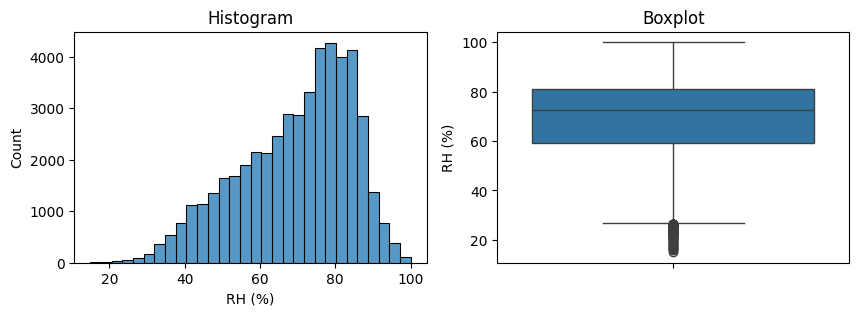

Skewness: -0.5974990482248299
Kurtosis: -0.37193295526350223


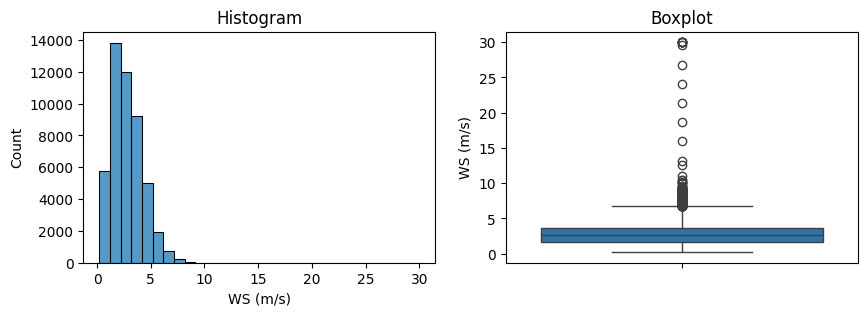

Skewness: 1.8129551100701877
Kurtosis: 20.097529853940422


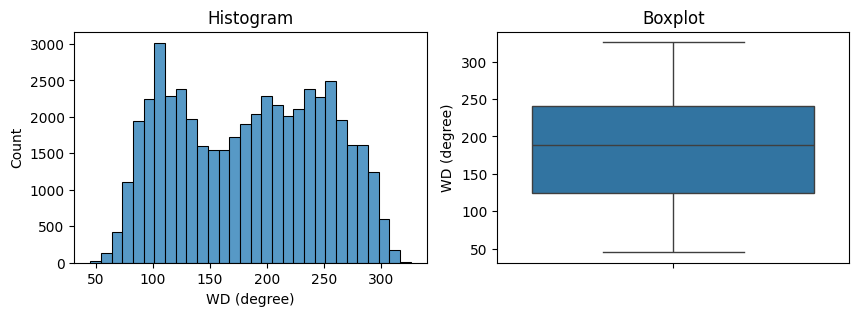

Skewness: -0.0006795048136696304
Kurtosis: -1.2180559793450965


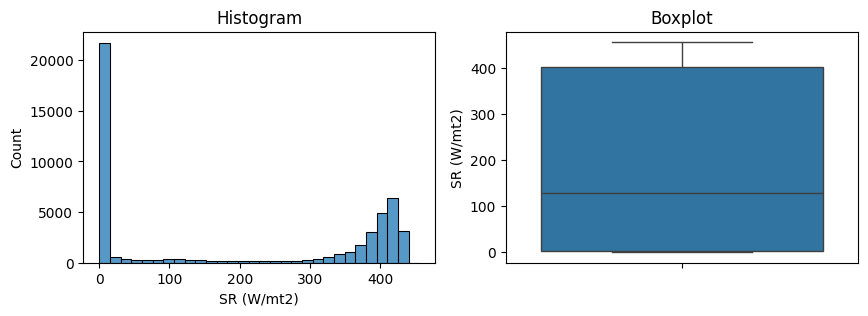

Skewness: 0.09417211838639215
Kurtosis: -1.8965212041343755


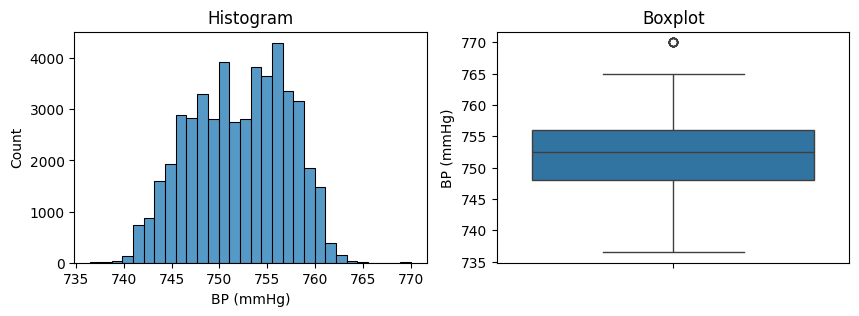

Skewness: -0.1653511025375769
Kurtosis: -0.8594853728217418


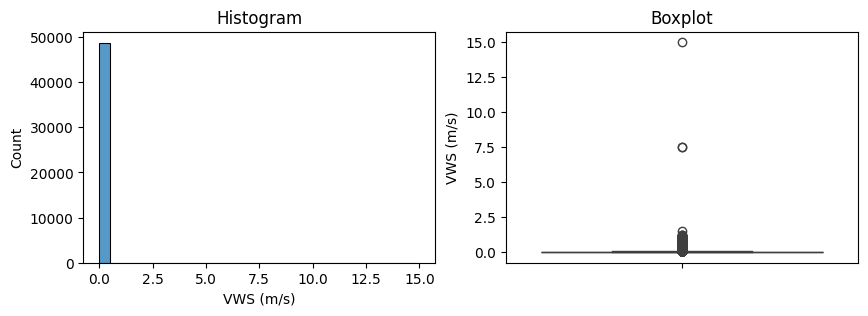

Skewness: 99.33305034118058
Kurtosis: 13836.73266768721


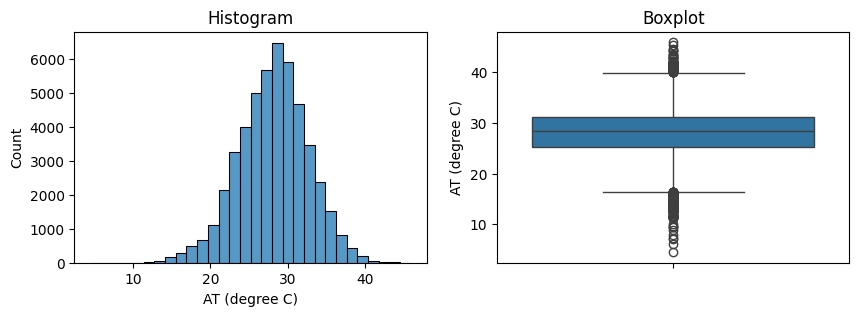

Skewness: -0.18580461283077138
Kurtosis: 0.20475117631810136


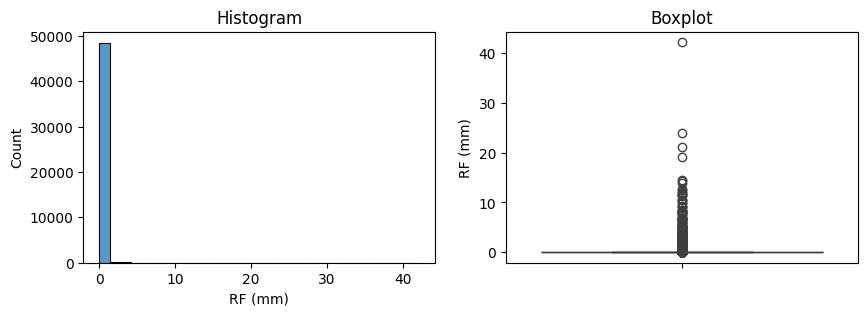

Skewness: 36.738648411713804
Kurtosis: 2359.1017240604356


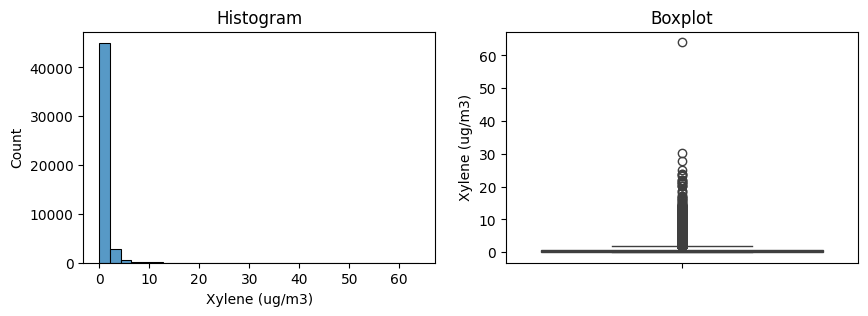

Skewness: 7.907515304943063
Kurtosis: 176.35955044105785


In [301]:
# Make a plot to check distribution
def check_distribution_outliers(df, columns):
    for i in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[i], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[i])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[i].skew())
        print('Kurtosis:', df[i].kurt())

check_distribution_outliers(df[numerical_columns], numerical_columns)

The outliers in this dataset are all meaningful and necessary for the time series analysis. Therefore, they will neither be imputed nor removed, as they represent valid variations in the data over time.

## Seasonality Check

In [302]:
def check_seasonality(df):
    # Pastikan index bertipe datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")

    # Extract hour and month
    df['hour'] = df.index.hour
    df['month'] = df.index.month

    numeric_cols = df.select_dtypes(include='number').columns

    # Plot average per hour
    plt.figure(figsize=(20, len(numeric_cols) * 3))
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols), 2, 2*i+1)
        sns.lineplot(x='hour', y=col, data=df)
        plt.title(f'{col} - Daily Seasonality (by Hour)')
        plt.xlabel('Hour of Day')
        plt.ylabel(col)

        plt.subplot(len(numeric_cols), 2, 2*i+2)
        sns.lineplot(x='month', y=col, data=df)
        plt.title(f'{col} - Yearly Seasonality (by Month)')
        plt.xlabel('Month')
        plt.ylabel(col)

    plt.tight_layout()
    plt.show()

    # Remove helper columns
    df.drop(columns=['hour', 'month'], inplace=True, errors='ignore')

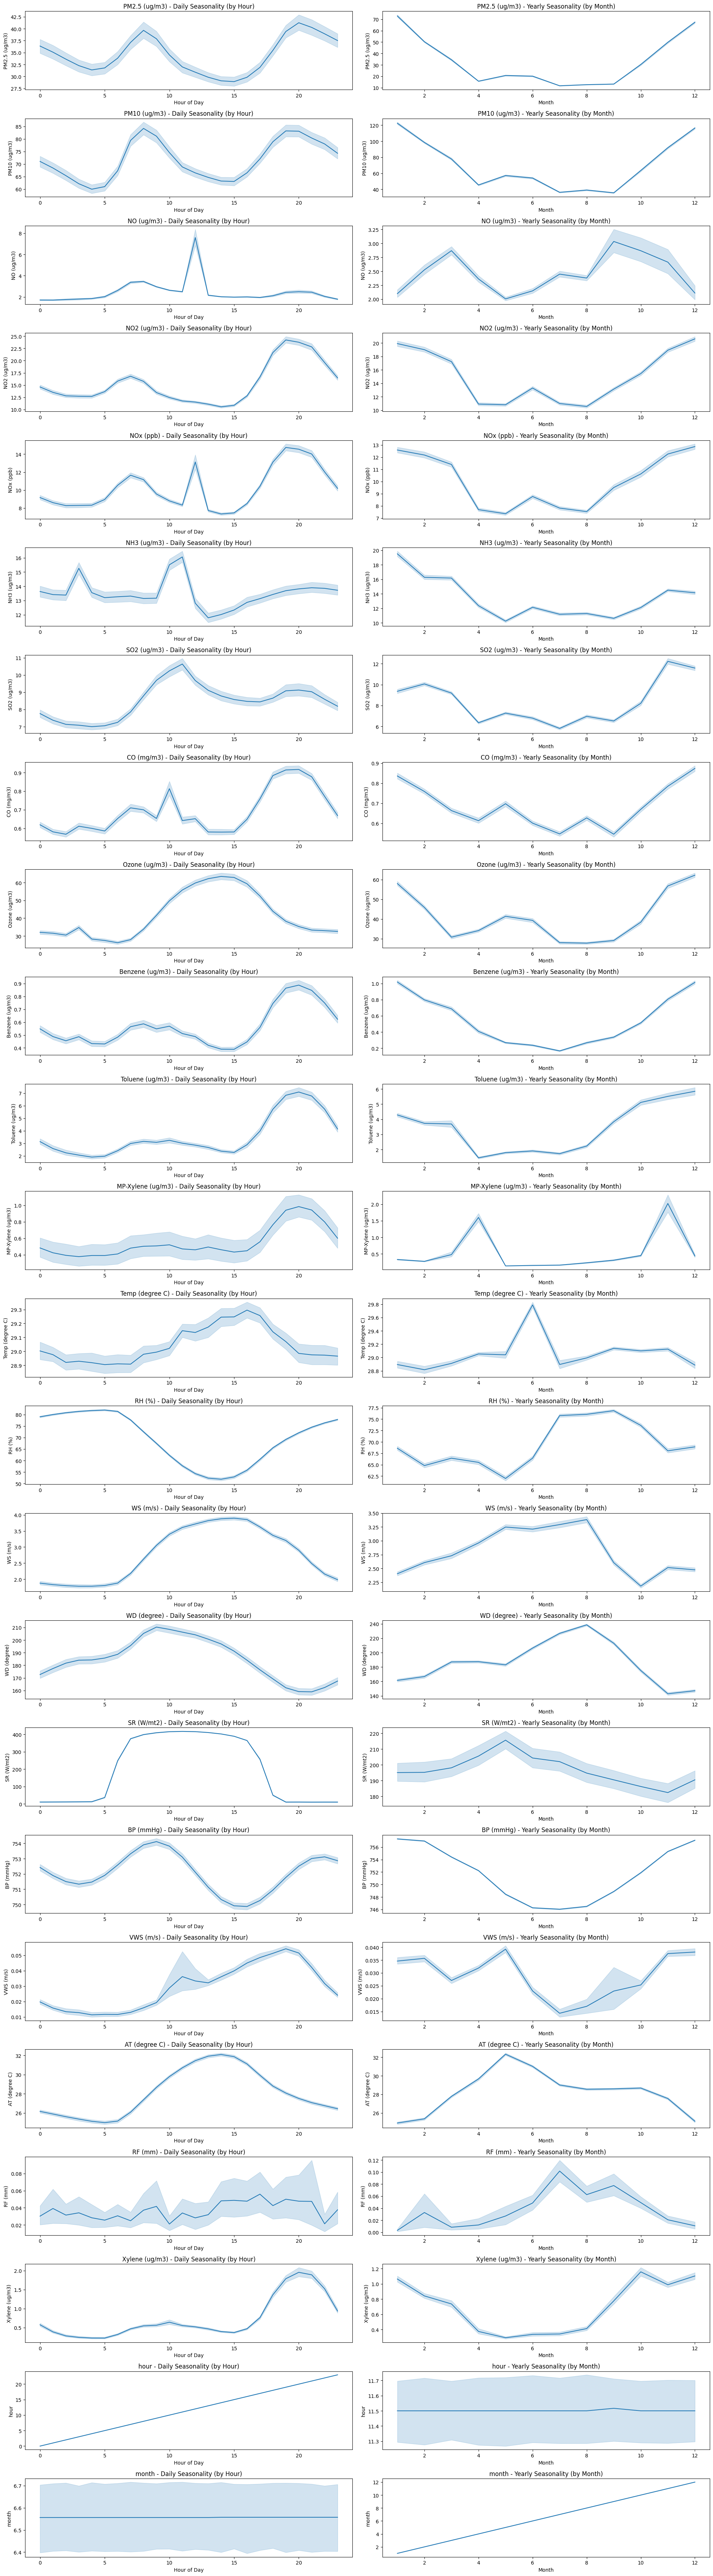

In [303]:
check_seasonality(df)

* **Clear daily seasonality** is observed in most pollutants such as PM2.5, PM10, NO₂, NOx, SO₂, CO, and O₃, showing peaks during morning and evening hours (likely due to traffic).
* **Monthly patterns** are also visible, especially in O₃, PMs, SO₂, and weather-related features like SR (solar radiation), RH (%), and Temp (°C).
* **Temperature, RH, SR, and BP** exhibit strong yearly seasonality, consistent with expected climate cycles.
* **CO and VOCs** (Toluene, Benzene, Xylene) show weaker and more irregular seasonality, possibly due to sporadic emissions or sensor variability.
* **RF (Rainfall)** has no clear daily trend and moderate monthly pattern.
* **VWS and WS** show slight daily cycles, but patterns are noisier than others.

## Correlation Heatmap

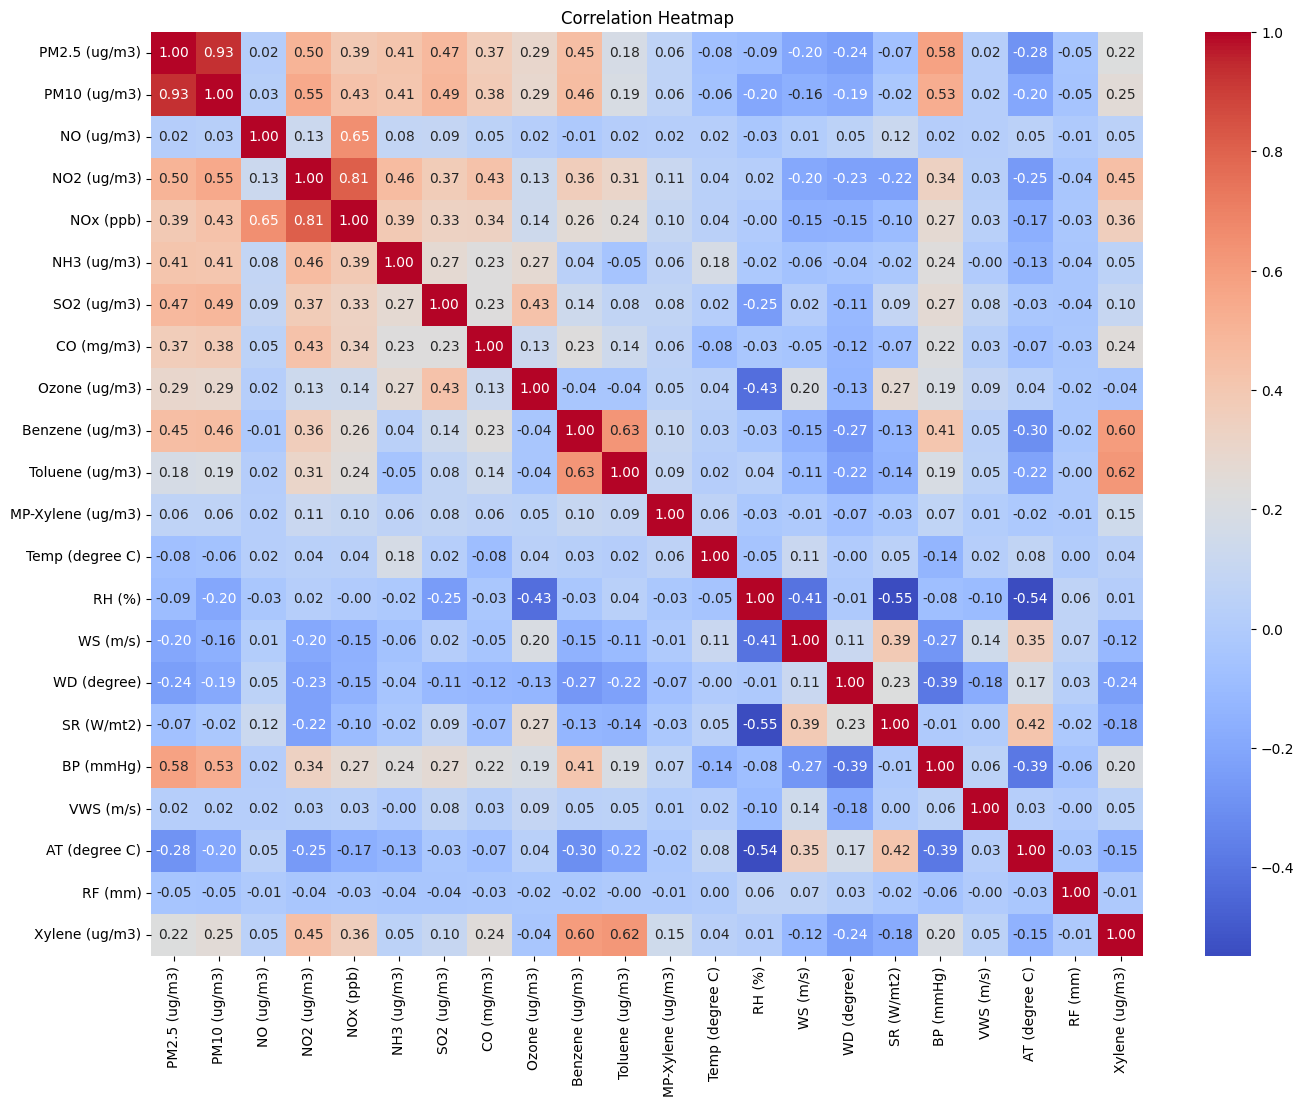

In [304]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

* **Strong positive correlations:**

  * **PM2.5 & PM10**: ρ ≈ 0.93 → highly collinear, both represent particulate matter.
  * **Toluene & Xylene**: ρ ≈ 0.62 → both are volatile organic compounds (VOCs).
  * **Benzene & Toluene/Xylene**: ρ ≈ 0.6 → indicates VOC cluster behavior.

* **Strong negative correlations:**

  * **AT (°C) & RH (%)**: ρ ≈ –0.55 → higher temperature tends to reduce humidity.
  * **RH (%) & Temp (°C), WS, SR**: all show moderate-to-strong inverse relationship.

* **Target (AT °C) correlations:**

  * **Negatively correlated** with PM2.5, PM10, NO₂, RH (%), VWS.
  * **Positively correlated** with SR (ρ ≈ 0.42), BP (ρ ≈ 0.39), Temp (ρ ≈ 1.00) — as expected.

* **Low correlation variables:**

  * MP-Xylene, NO, NH3 show weak correlations with most other features.

## Feature Selection

In [ ]:
# Parameters
target_column = 'AT (degree C)'  
max_lag = 3                      
p_threshold = 0.05              

features = [col for col in df.columns if col != target_column]

# Granger causality test for each feature
granger_pvals = {}

for feature in features:
    try:
        # Drop rows with missing values for the two columns
        data_for_test = df[[target_column, feature]].dropna()

        # Granger test requires at least (max_lag + 1) observations
        if data_for_test.shape[0] > max_lag + 1:
            result = grangercausalitytests(data_for_test, maxlag=max_lag, verbose=False)
            p_values = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
            granger_pvals[feature] = min(p_values)
        else:
            granger_pvals[feature] = None
    except Exception:
        granger_pvals[feature] = None

# Create and sort result DataFrame
granger_df = pd.DataFrame.from_dict(granger_pvals, orient='index', columns=[f'p-value (Granger, maxlag={max_lag})'])
granger_df = granger_df.dropna().sort_values(by=granger_df.columns[0])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

In [306]:
# Select features with p-value < threshold
selected_features = granger_df[granger_df.iloc[:, 0] < p_threshold].index.tolist()

# Display
print("Top Granger-causal features:\n")
print(granger_df.head())
print(f"\nSelected features (p < {p_threshold}):\n", selected_features)

Top Granger-causal features:

               p-value (Granger, maxlag=3)
RH (%)                        0.000000e+00
SR (W/mt2)                    0.000000e+00
WD (degree)                  3.004957e-271
BP (mmHg)                    1.164023e-268
Ozone (ug/m3)                2.608895e-252

Selected features (p < 0.05):
 ['RH (%)', 'SR (W/mt2)', 'WD (degree)', 'BP (mmHg)', 'Ozone (ug/m3)', 'WS (m/s)', 'Xylene (ug/m3)', 'Toluene (ug/m3)', 'NO (ug/m3)', 'Benzene (ug/m3)', 'Temp (degree C)', 'VWS (m/s)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'PM2.5 (ug/m3)', 'RF (mm)', 'SO2 (ug/m3)', 'NH3 (ug/m3)', 'NOx (ppb)', 'CO (mg/m3)', 'MP-Xylene (ug/m3)']


**Top Granger-Causal Features**

The top five features with the strongest Granger causality (based on p-values with maxlag=3) are **RH (%)**, **SR (W/mt2)**, **WD (degree)**, **BP (mmHg)**, and **Ozone (ug/m3)**. These features have extremely low p-values, indicating a strong temporal influence on the target variable.

**Selected Features (p < 0.05)**

A total of **21 features** were selected for modeling based on the Granger causality test, as their p-values were below 0.05. These features showed significant predictive relationships with the target over time.

In [309]:
feature_columns = selected_features
target_column = 'AT (degree C)'

# Split Data

In [310]:
X_raw = df[feature_columns + [target_column]].values
y_raw = df[[target_column]].values

The dataset is split into **X** and **y**, where **X** includes both the features and the target column to preserve temporal context for time series analysis. Meanwhile, **y** contains only the target column, which will be used as the prediction target.

In [311]:
print("X_raw:", X_raw.shape)
print("y_raw:", y_raw.shape)

X_raw: (48802, 22)
y_raw: (48802, 1)


In [312]:
total_rows = len(df)
train_end = int(0.8 * total_rows)
val_end = int(0.9 * total_rows)

In [313]:
X_train_raw = X_raw[:train_end]
X_val_raw = X_raw[train_end:val_end]
X_test_raw = X_raw[val_end:]

y_train_raw = y_raw[:train_end]
y_val_raw = y_raw[train_end:val_end]
y_test_raw = y_raw[val_end:]

The dataset is split into 80% for training, 10% for validation, and 10% for testing. This ensures that the model is trained on a large portion of the data while still being properly evaluated on unseen data during validation and final testing stages.

# Scaling

In [314]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [315]:
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_val_scaled = scaler_X.transform(X_val_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_val_scaled = scaler_y.transform(y_val_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

We use **MinMaxScaler** because it is well-suited for time series data, preserving the scale and temporal patterns. The scaler is **fit and transformed** on **X**, while **y** is only **transformed**, ensuring consistent scaling without introducing data leakage.

# Windowing

In [316]:
def create_sequences(X, y, window_size=5, horizon=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - horizon + 1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size+horizon-1])
    return np.array(X_seq), np.array(y_seq)

This function is used to prepare time series data into an input-output format suitable for model training. A **window size of 5** means the model will look at the previous 5 time steps as input to predict a future value.

In [317]:
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

In [318]:
print("X_train:", X_train_seq.shape)
print("y_train:", y_train_seq.shape)
print("X_val:", X_val_seq.shape)
print("y_val:", y_val_seq.shape)
print("X_test:", X_test_seq.shape)
print("y_test:", y_test_seq.shape)

X_train: (39036, 5, 22)
y_train: (39036, 1)
X_val: (4875, 5, 22)
y_val: (4875, 1)
X_test: (4876, 5, 22)
y_test: (4876, 1)


# Modelling

## Baseline Model

In [319]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dense(1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


A **LSTM model** is built with a **hidden size of 10**, allowing it to capture temporal dependencies in the time series data. The model uses a **single-layer regressor** as the output layer with a **linear activation function**, which is appropriate for continuous value prediction tasks such as regression.

In [320]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae', 'mse']
)

In [321]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0559 - mae: 0.1864 - mse: 0.0559 - val_loss: 0.0176 - val_mae: 0.1107 - val_mse: 0.0176
Epoch 2/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0062 - mae: 0.0615 - mse: 0.0062 - val_loss: 0.0102 - val_mae: 0.0836 - val_mse: 0.0102
Epoch 3/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0041 - mae: 0.0498 - mse: 0.0041 - val_loss: 0.0056 - val_mae: 0.0620 - val_mse: 0.0056
Epoch 4/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0026 - mae: 0.0387 - mse: 0.0026 - val_loss: 0.0024 - val_mae: 0.0400 - val_mse: 0.0024
Epoch 5/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0017 - mae: 0.0305 - mse: 0.0017 - val_loss: 0.0015 - val_mae: 0.0313 - val_mse: 0.0015
Epoch 6/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0012 - mae: 0.0253 - mse: 0.0012 - val_loss: 0.0013 - val_mae: 0.0287 - val_mse: 0.0013
Epoch 7/20
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0010 - mae: 0.0228 - m

In [322]:
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_seq)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


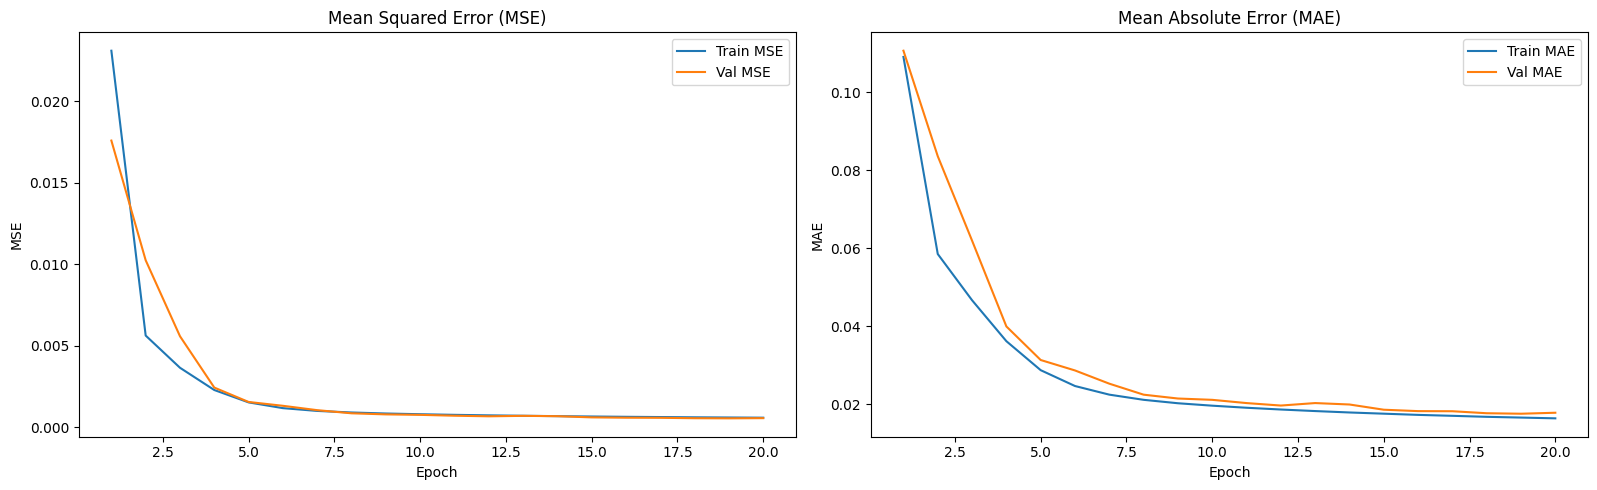

In [323]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(24, 5))

# === Plot MSE (Loss) ===
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'], label='Train MSE')
plt.plot(epochs, history.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE)')
plt.legend()

# === Plot MAE ===
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['mae'], label='Train MAE')
plt.plot(epochs, history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE)')
plt.legend()

# # === Plot R² ===
# plt.subplot(1, 3, 3)
# plt.plot(epochs, history.history['r2_score'], label='Train R²')
# plt.plot(epochs, history.history['val_r2_score'], label='Val R²')
# plt.xlabel('Epoch')
# plt.ylabel('R²')
# plt.title('R-squared (R²)')
# plt.legend()

plt.tight_layout()
plt.show()

* Both **training and validation loss (MSE and MAE)** consistently decrease over epochs.
* The **gap between training and validation errors is very small**, indicating strong generalization without overfitting.
* The model reaches a **very low MAE (< 0.02)** and **MSE close to 0**, which suggests highly accurate predictions.
* There are **no signs of instability** or divergence in the validation curve, confirming the model is learning well and robust.
* The curve flattens toward the end, showing convergence.

**Conclusion:**
The model is well-optimized and generalizes properly.

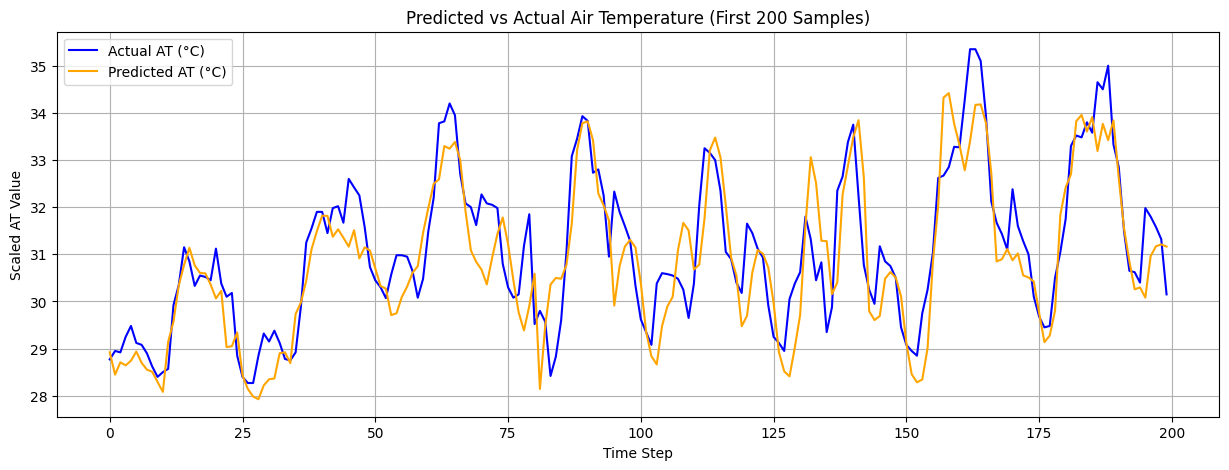

In [324]:
plt.figure(figsize=(15, 5))
plt.plot(y_test[:200], label='Actual AT (°C)', color='blue')
plt.plot(y_pred[:200], label='Predicted AT (°C)', color='orange')
plt.title('Predicted vs Actual Air Temperature (First 200 Samples)')
plt.xlabel('Time Step')
plt.ylabel('Scaled AT Value')
plt.legend()
plt.grid(True)
plt.show()

* The **orange line (predicted)** is very close to the **blue line (actual)** across most points.
* The model follows the **up-and-down pattern** of air temperature quite well.
* Peaks and dips are mostly predicted correctly, with only small differences.
* There are no major errors or strange jumps in the predictions.
* This shows that the model learned the pattern of temperature and can predict it accurately.

**Conclusion:**
The model gives good and reliable temperature predictions that closely match the real values.

## Modified Model

In [325]:
modified_model = Sequential()
modified_model.add(LSTM(units=64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
modified_model.add(Dense(1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The `modified_model` differs from the baseline by using a larger LSTM layer with **64 units** instead of 10, allowing it to capture more complex temporal patterns. However, it still uses a **single dense output layer with linear activation**, keeping the output structure the same as the baseline.

In [326]:
modified_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae', 'mse']
)

In [327]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [328]:
history_modified = modified_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0869 - mae: 0.1976 - mse: 0.0869 - val_loss: 0.0052 - val_mae: 0.0592 - val_mse: 0.0052
Epoch 2/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0027 - mae: 0.0392 - mse: 0.0027 - val_loss: 0.0021 - val_mae: 0.0370 - val_mse: 0.0021
Epoch 3/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0015 - mae: 0.0276 - mse: 0.0015 - val_loss: 0.0016 - val_mae: 0.0318 - val_mse: 0.0016
Epoch 4/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012 - mae: 0.0248 - mse: 0.0012 - val_loss: 0.0013 - val_mae: 0.0284 - val_mse: 0.0013
Epoch 5/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0011 - mae: 0.0229 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0258 - val_mse: 0.0011
Epoch 6/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.0655e-04 - mae: 0.0212 - mse: 9.0655e-04 - val_loss: 9.0354e-04 - val_mae: 0.0234 - val_mse: 9.0354e-04
Epoch 7/100
1220/1220 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 8.0

Callbacks are used to find the most optimal model during the 100 training epochs. This ensures that the best-performing model is saved, rather than relying solely on the final epoch.

In [329]:
y_pred_mod = modified_model.predict(X_test_seq)
y_pred_improved = scaler_y.inverse_transform(y_pred_mod)
y_test_improved = scaler_y.inverse_transform(y_test_seq)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


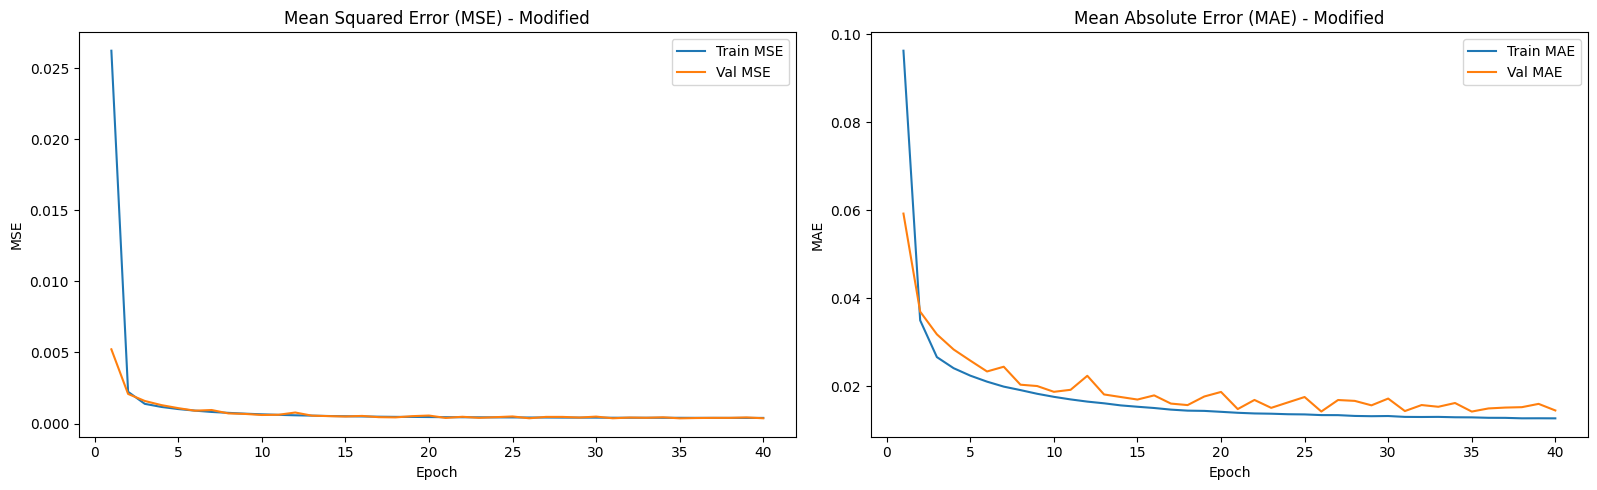

In [330]:
epochs = range(1, len(history_modified.history['loss']) + 1)

plt.figure(figsize=(24, 5))

# === Plot MSE (Loss) ===
plt.subplot(1, 3, 1)
plt.plot(epochs, history_modified.history['loss'], label='Train MSE')
plt.plot(epochs, history_modified.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) - Modified')
plt.legend()

# === Plot MAE ===
plt.subplot(1, 3, 2)
plt.plot(epochs, history_modified.history['mae'], label='Train MAE')
plt.plot(epochs, history_modified.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) - Modified')
plt.legend()

#

plt.tight_layout()
plt.show()

* Both **training and validation loss (MSE and MAE)** decrease smoothly and consistently throughout training.
* The **gap between training and validation errors is minimal**, which indicates that the model generalizes well to unseen data.
* The model achieves a **very low MAE (below 0.02)** and **MSE approaching 0**, showing high prediction accuracy.
* The validation curves do not show any spikes or divergence, meaning the model is **stable and not overfitting**.
* The loss curves flatten toward the end, indicating the model has **converged properly**.

**Conclusion**

Compared to the earlier model, this modified version:

* Converges faster
* Achieves lower final MSE and MAE
* Shows better alignment between training and validation curves
* Is more stable across epochs

**Overall, the modified model performs better and is more reliable than the previous version.**

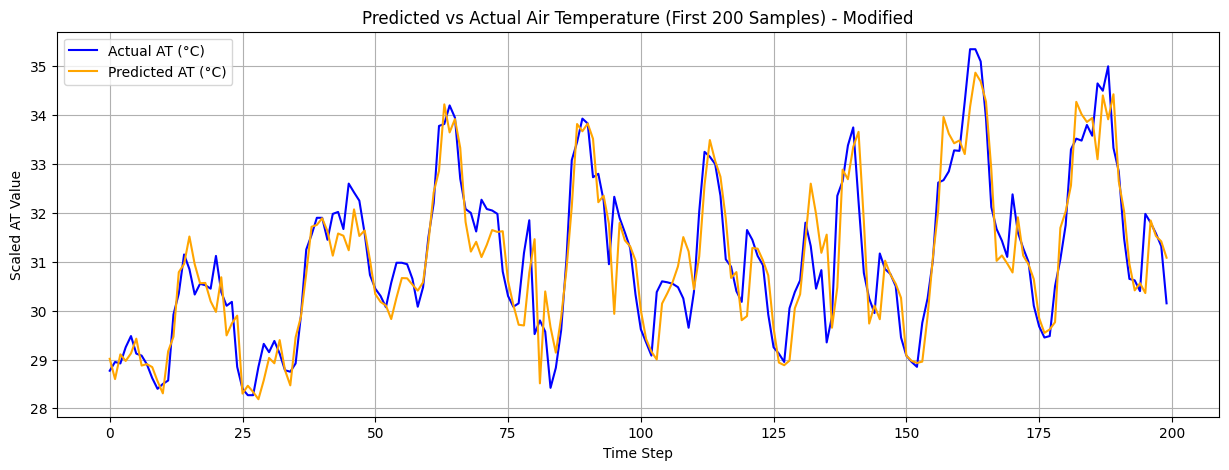

In [331]:
plt.figure(figsize=(15, 5))
plt.plot(y_test_improved[:200], label='Actual AT (°C)', color='blue')
plt.plot(y_pred_improved[:200], label='Predicted AT (°C)', color='orange')
plt.title('Predicted vs Actual Air Temperature (First 200 Samples) - Modified')
plt.xlabel('Time Step')
plt.ylabel('Scaled AT Value')
plt.legend()
plt.grid(True)
plt.show()

* The **orange line (predicted)** closely follows the **blue line (actual)** across all 200 samples.
* The model successfully captures both **short-term variations** and **larger seasonal shifts**.
* Peaks and dips are predicted with high accuracy, with only minor deviations in timing or magnitude.
* There is **minimal lag** and the predicted values remain smooth and well-aligned throughout the range.
* This shows that the model has **learned the temporal pattern of air temperature effectively**.

**Conclusion**

Compared to the earlier model:

* The modified model shows **tighter alignment** between predicted and actual lines.
* It handles both **trend and volatility** more accurately, especially in sharper peaks and transitions.
* Prediction is **more stable** with fewer jagged or erratic outputs.
* Overall, the modified model provides **more accurate and visually consistent predictions**.

**Final Verdict:** The modified model not only achieves lower error metrics but also performs significantly better in reproducing real-world temperature patterns.

## Evaluation

In [332]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Flatten true and predicted values
y_true = y_test.flatten()
y_pred = y_pred.flatten()
y_true_mod = y_test_improved.flatten()
y_pred_mod = y_pred_improved.flatten()

# Evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return [mae, mse, r2, mape]

# Compute metrics
metrics_baseline = evaluate_model(y_true, y_pred)
metrics_modified = evaluate_model(y_true_mod, y_pred_mod)

# Create DataFrame
results_df = pd.DataFrame(
    [metrics_baseline, metrics_modified],
    columns=['MAE', 'MSE', 'R2', 'MAPE'],
    index=['Baseline Model', 'Modified Model']
)

# Display results
print(results_df)

                     MAE       MSE        R2      MAPE
Baseline Model  0.666300  0.750913  0.893491  0.021601
Modified Model  0.412514  0.320571  0.954531  0.013302


- **MAE (Mean Absolute Error):**
  - Decreased from **0.6663** to **0.4125**
  - Indicates that the modified model makes more accurate predictions on average

- **MSE (Mean Squared Error):**
  - Dropped from **0.7509** to **0.3206**
  - Shows that large errors are significantly reduced, improving overall precision

- **R² Score (Coefficient of Determination):**
  - Increased from **0.8935** to **0.9545**
  - The modified model explains more variance in the target variable (better fit to the data)

- **MAPE (Mean Absolute Percentage Error):**
  - Lowered from **0.0216** to **0.0133**
  - Confirms that the model’s percentage error is smaller and more consistent across samples

**Conclusion**

The **modified model outperforms the baseline model across all key metrics**. It is more accurate, generalizes better, and produces lower error in both absolute and percentage terms.


# Bonus Question

Apakah problem ini mungkin menggunakan time series multivariate, bagaimana mengetahui apakah problem tersebut dapat menjadi multivariate  jelaskan jawaban anda untuk problem ini!

**Ya, cocok dan sangat memungkinkan.**

**Alasan:**

1. **Memiliki banyak variabel input waktu-ke-waktu**
   Seperti: PM2.5, PM10, NO, CO, suhu, kelembapan, kecepatan angin, dll — semua terukur setiap jam. Ini memenuhi syarat multivariate time series.

2. **Target variabel `AT (Apparent Temperature)` dipengaruhi banyak faktor**
   AT tidak hanya bergantung pada suhu, tetapi juga kelembapan, polusi, radiasi matahari, dan angin — menjadikannya ideal untuk diprediksi dengan pendekatan multivariat.

**Kesimpulan:**
Problem ini valid untuk diselesaikan dengan multivariate time series karena memiliki banyak fitur relevan yang saling memengaruhi secara temporal.
